<a href="https://colab.research.google.com/github/Bensmail-anis/Mathematical-Foundations-of-Neural-Networks-with-Micrograd/blob/main/Notebooks/Building_Micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## **1. Introduction to Derivatives and Slope**

In mathematics, the derivative of a function represents the rate at which the function's value changes as its input changes.

Imagine a curve drawn on a graph. The slope of the curve at a particular point tells us how steep the curve is. A positive slope indicates an upward trend, and a negative slope indicates a downward trend.

**Example: Visualizing a Function and Its Tangent Slope**

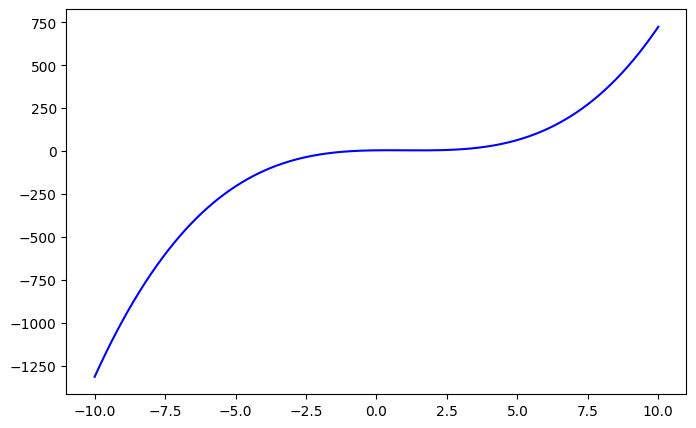

In [14]:
def function(x):
    return x**3 - 3 * x**2 + 2 * x + 5

# Generate x values
x = np.linspace(-10, 10, 400)
y = function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label='$y = x^2$', color='blue')

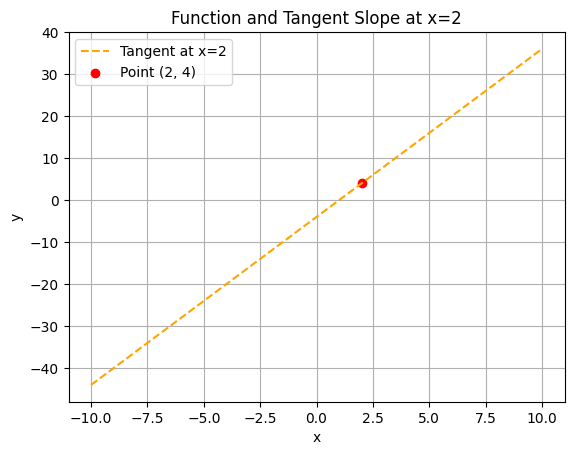

In [11]:
# Pick a point x0 to visualize the slope
x0 = 2
y0 = function(x0)

def derivative_at_point(x):
    return 3 * x**2 - 6 * x + 2

slope = derivative_at_point(x0)

# Equation of the tangent line: y = mx + b
b = y0 - slope * x0
tangent_line = slope * x + b

plt.plot(x, tangent_line, '--', label=f'Tangent at x={x0}', color='orange')
plt.scatter(x0, y0, color='red', label=f'Point ({x0}, {y0})')

plt.title('Function and Tangent Slope at x=2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## **2. Derivative: Contribution of a Variable in a Function**

In neural networks, we often deal with functions involving multiple variables. Understanding how changing a particular variable impacts the function's output is crucial. This "contribution" is exactly what the derivative captures.

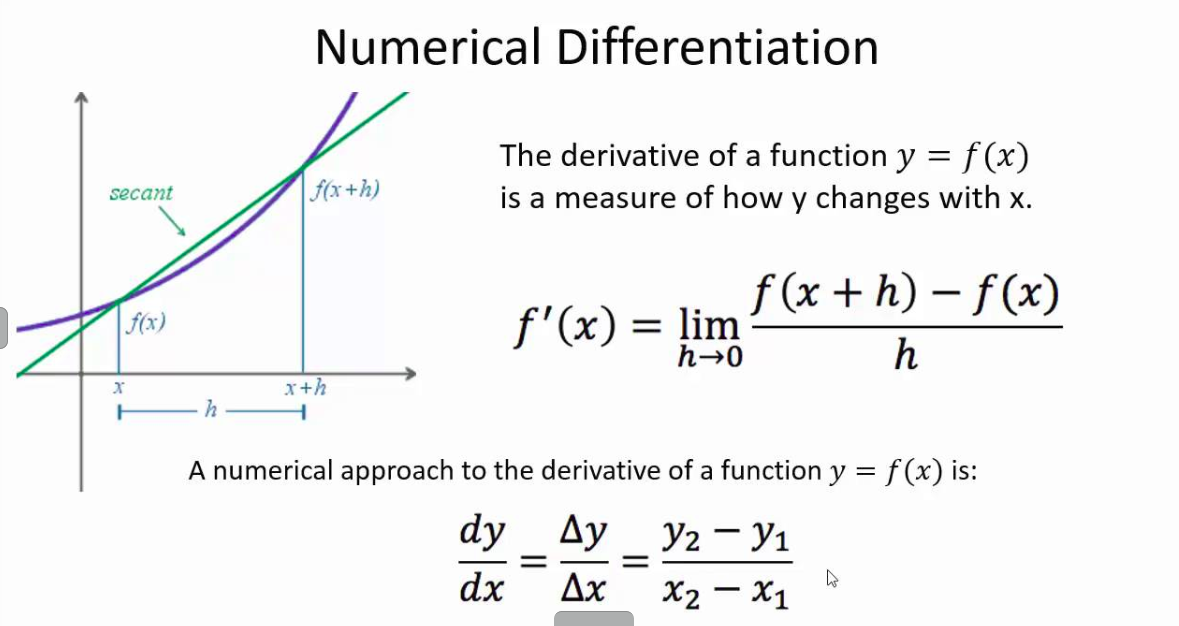

Think of the slope as measuring how steep a hill is. If the hill rises quickly as you take a step forward, the slope is steep (positive or negative).

The formula (f(x+h)−f(x))/h approximates the instantaneous slope by calculating the rise over a small step (run). The smaller the step size (
ℎ
h), the closer the approximation to the true slope.

In [19]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c
slope_c = (d2 - d1) / h
slope_c

0.9999999999976694

**Here, the change in c directly affects the function's output linearly because c is added directly to the result. Therefore, the contribution of c is 1.**

In [21]:
d1 = a * b + c
b += h
d2 = a * b + c
slope_b = (d2 - d1) / h
slope_b

2.0000000000042206

**Thus, b contributes proportionally to a because b is multiplied by a.**

So :
- When perturbing c, the slope equals 1 because c contributes directly and linearly.
- When perturbing b, the slope equals a, showing how strongly b affects the output when combined with a.
- When perturbing a, the slope equals b, indicating its contribution when multiplied by b.

- This example shows how each variable's contribution can be captured by derivatives (numerical or symbolic). It's a fundamental concept for backpropagation in neural networks.

## **3. Gradient: Vector of Partial Derivatives**

The gradient is simply a vector containing all the partial derivatives of a function with respect to its variables. It points in the direction of the steepest ascent.

**Example: Gradient Visualization for a 2D Function**

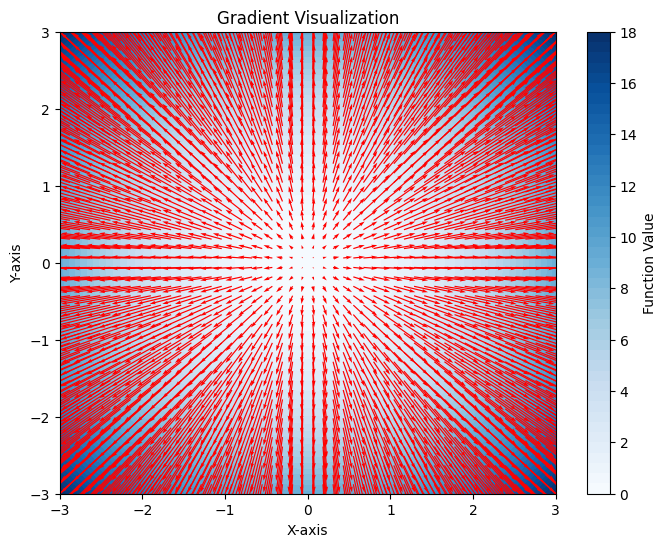

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define a simple 2D function: A bowl shape
def function(x, y):
    return x**2 + y**2

# Create a grid for visualization
x = np.linspace(-3, 3, 50)
y = np.linspace(-3, 3, 50)
X, Y = np.meshgrid(x, y)
Z = function(X, Y)

# Calculate gradients
dZ_dx = 2 * X
dZ_dy = 2 * Y

# Plot the contour and gradients
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='Blues')
plt.colorbar(label='Function Value')
plt.quiver(X, Y, dZ_dx, dZ_dy, color='red', angles='xy', scale_units='xy', scale=8)
plt.title('Gradient Visualization')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


- The contour plot represents the function's values (the height of the mountain).
- The red arrows indicate the gradient direction (where the slope increases the most).
- Notice how near the center, the arrows get smaller. This is because we're near the minimum, where the gradient approaches zero.

# Micrograd: Understanding Forward and Backward Propagation
we will implement a simple automatic differentiation library called micrograd. This custom implementation will help us build an intuitive understanding of how neural networks perform forward and backward propagation to learn from data. Instead of relying on existing libraries like TensorFlow or PyTorch, we will develop key components from scratch to gain a deeper insight into how gradients are computed.

### **Class Definition: Value**

At the heart of micrograd is the Value class. This class represents a node in the computation graph, where each node holds a scalar value and tracks how it was computed.

#### **Attributes of Value**

*   data: The scalar value held by this node.
    
*   grad: The gradient of this value, used for backpropagation.
    
*   \_backward: A function to compute the gradient for this node during backpropagation.
    
*   \_prev: A set of parent nodes (used to track dependencies in the computation graph).
    
*   \_op: The operation that produced this value (useful for visualization).
    
*   label: Optional label for visualization.

#### **Methods of Value**

Let's break down each key method in the class.

#### 1\. **Constructor (\_\_init\_\_)**

In [25]:
class Value:
  None

In [ ]:
def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label


**Description:**

*   Initializes a Value object with a given scalar value (data).
    
*   Initializes the gradient to zero (grad = 0.0).
    
*   \_children keeps track of the parent nodes that contribute to this value.
    
*   \_op stores the operation that produced this value, helping us visualize the computation graph.

#### 2\. **Addition (\_\_add\_\_)**

In [22]:
def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
    out._backward = _backward

    return out


**1\. Forward Propagation (Computing the Output)**

When we add two values, say a and b, the result is:

c=a+b

This is simple addition. The result c is stored in the Value object named out. (the children are saved too as we discussed earlier)
  
At this stage, we have computed the forward pass.

- out object represent the next layer

### **Understanding the Chain Rule in Backpropagation**

The **chain rule** is a fundamental concept in calculus that helps us compute gradients in a computational graph. It allows us to break down complex derivative calculations into simpler parts.

### **Definition of the Chain Rule**

If we have a function **z** that depends on **y**, and **y** depends on **x**, then the rate of change of **z** with respect to **x** is given by:

dz/dx=(dz/dy)∗(dy/dx)

This means that to find how **z** changes with respect to **x**, we first compute how **z** changes with **y** and how **y** changes with **x**, then multiply these two derivatives.

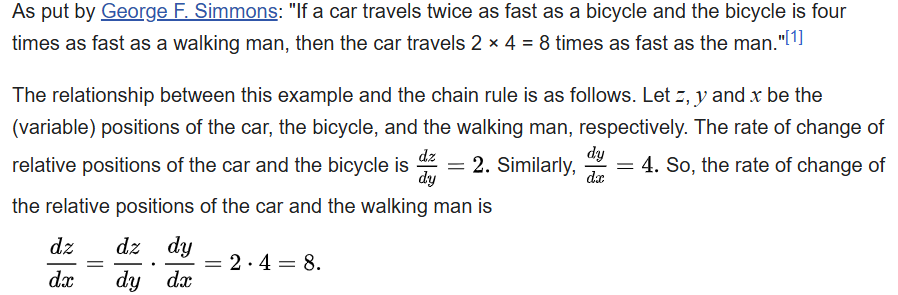
### **Applying the Chain Rule to Addition in Micrograd**

Let's go back to the addition operation:

c=a+b

From the chain rule, if c depends on a and b, and we are computing derivatives with respect to some loss function L, we apply:

dc/da=1,dc/db=1

Using the chain rule for backpropagation:

dL/da=(dL/dc)∗(dc/da)=out.grad∗1

dL/db=(dL/dc)∗(dc/db)=out.grad∗1

Where out.grad represents dL/dc (the gradient of c received from the next layer in the graph).

### **Example with a Computational Graph**

Let's assume we have the following operations:

1.  a = 3, b = 5
    
2.  c = a + b = 8
    
3.  The loss function gives dL/dc = 2
    

Applying the chain rule:

dL/da=2∗1=2
dL/db=2∗1=2

So after backpropagation:

*   a.grad = 2
    
*   b.grad = 2
    

This shows how the chain rule distributes gradients backward through the network.

### 3\. **Multiplication (\_\_mul\_\_)**

In [23]:
def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward

    return out


#### **1.Backpropagation (Computing the Gradients Using Chain Rule)**

In backpropagation, we need to determine how much c changes when a or b changes. This means we compute:

*   dc/da = b
    
*   dc/db = a
    

Since multiplication follows the **product rule** of differentiation:

d(a×b)/da=b

d(a×b)/db=a

#### **2\. Gradient Flow Rule**

In backpropagation, the gradients from c (represented as out.grad) get passed to a and b as follows:

da=b×out.grad

db=a×out.grad

This means each value receives a portion of the gradient based on its counterpart.

#### **3\. Example: Backpropagation Step**

Let’s assume the loss function provides:

dc/dL=2

Since we know:

*   dc/da = b = 5
    
*   dc/db = a = 3
    

We now compute:

dL/da=(dc/dL)∗(dc/da)=2∗5=10

dL/db=(dc/dL)∗(dc/db)=2∗3=6

So after backpropagation:

*   The gradient of a (a.grad) becomes **10**.
    
*   The gradient of b (b.grad) becomes **6**.
    


#### 4\. **power (\_\_pow\_\_)**

In [24]:
def __pow__(self, other):
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

Since we use this function in a computational graph, we must propagate the gradient backward. Using the **chain rule**:

dL/da=(dL/dc)×(dc/da)

where if c = a**b:

*   dc/da=b⋅a**(b-1)
  (from the power rule).
    
*   out.grad represents dL/dc, the gradient received from the next layer.
    

Thus, the gradient update in code is:

a.grad+=b⋅a**(b−1)⋅out.grad

**1\. Hyperbolic Tangent (tanh)**
---------------------------------
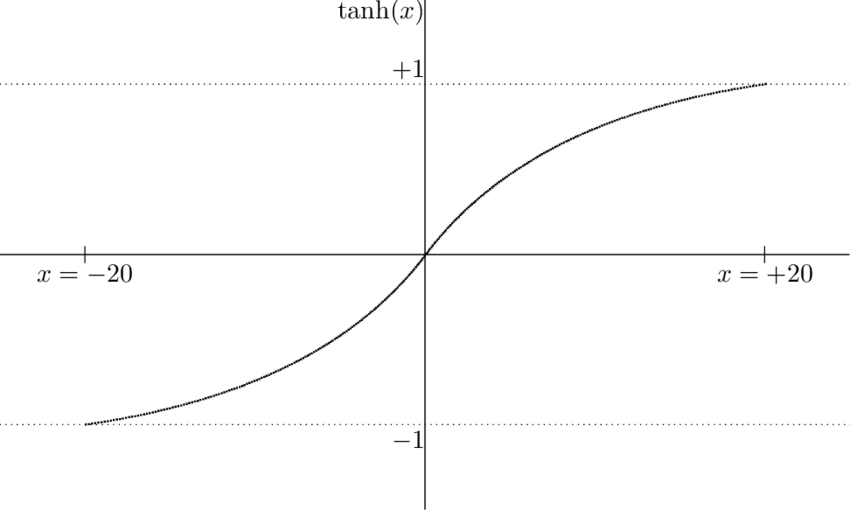

In [ ]:
def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out





The **tanh function** is a commonly used activation function in neural networks.

This function **squashes** values into the range **(-1, 1)**, making it useful in deep learning.

### **Derivative of tanh(x)**

Using calculus, the derivative of tanh(x) is:


dtanh(x)/dx=1-tanh(x)**2

This result comes from differentiating the definition of tanh(x) using the quotient rule.

### **Backpropagation**

To propagate gradients through the computational graph, we apply the **chain rule**:

dL/dx=(dL/dt)×(dt/dx)

Since:

dt/dx=1−tanh⁡(x)**2

the code correctly updates the gradient as:

self.grad+=(1−t**2)×out.grad

*   We repeat this process for each element, just as we did for the exponential function (exp).
    
*   Next, we implement **topological sorting** to determine the correct order for backpropagation.
    

### **Why Topological Sorting?**

Backpropagation requires computing gradients in the correct sequence, ensuring that dependencies are resolved before processing each node. Since our computation graph is **directed and acyclic (DAG)**, we use topological sorting to traverse it in **reverse order**, guaranteeing that each value's gradient is correctly accumulated before propagating to its inputs.

#### **How It Works in Code:**

1.  **Build the Topological Order (topo list)**:
    
    *   We traverse the graph recursively, adding each node only after all its dependencies (children) are visited.
        
2.  **Reverse Order for Backpropagation**:
    
    *   We initialize the gradient of the final output as 1.0, representing the total derivative of the loss with respect to itself.
        
    *   We iterate over the nodes in **reverse topological order**, calling each node’s \_backward() function to propagate gradients backward.
        

This ensures that gradients flow correctly from the final output back to the inputs.

In [ ]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)


**Let's look to the big picture now**

In [7]:
import math
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

 **Graph Visualization**
    
*   To better understand how values interact and propagate gradients, we represent the computation as a **graph** using graphviz. This helps us see the dependencies between operations and how gradients flow during backpropagation.

    
 **Tracing the Computation Graph (trace function):**
    

*   We traverse the graph, identifying all nodes (values) and edges (connections between them).
    
*   Each node represents a computed value, and edges represent dependencies between values.
    
*   **Drawing the Graph (draw\_dot function):**
    
    *   Each value is displayed as a **rectangle** containing:
        
        *   The **label** (if assigned).
            
        *   The **computed data** value.
            
        *   The **gradient** (used for backpropagation).
            
    *   If a value results from an operation (e.g., addition, multiplication), we create a separate node for the **operation** and connect it to the value it produced.
        
    *   The graph is laid out **left to right (LR)** for clarity, showing the flow of computations leading to the final result.
        
*   This visualization allows us to **see the forward pass (computations)** and **track the backward pass (gradients flowing back)**, making it easier to debug and interpret the backpropagation process.

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In this example, we're building a simple computation for a neuron in a neural network. First, two inputs, x1 and x2, are defined with values 2.0 and 0.0, respectively. Then, the corresponding weights w1 and w2 are initialized with values -3.0 and 1.0. A bias term b is also set with a specific value. The weighted sums for each input are computed by multiplying x1 with w1 and x2 with w2. These are then added together, forming the total weighted input (x1w1 + x2w2). This sum is further combined with the bias term b to compute the pre-activation value n. Finally, the output o is calculated by applying the tanh activation function to the pre-activation value n. After computing this output, the backward() function is called to propagate the gradients for each operation in the computation graph, which allows for learning in a neural network by updating the weights and bias based on the loss function.

In [4]:
import math
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

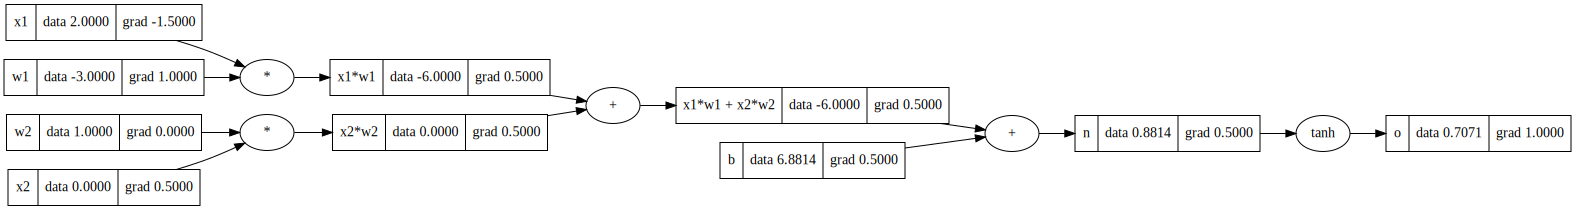

In [5]:
draw_dot(o)

-- Implementing tan(h0) at low level

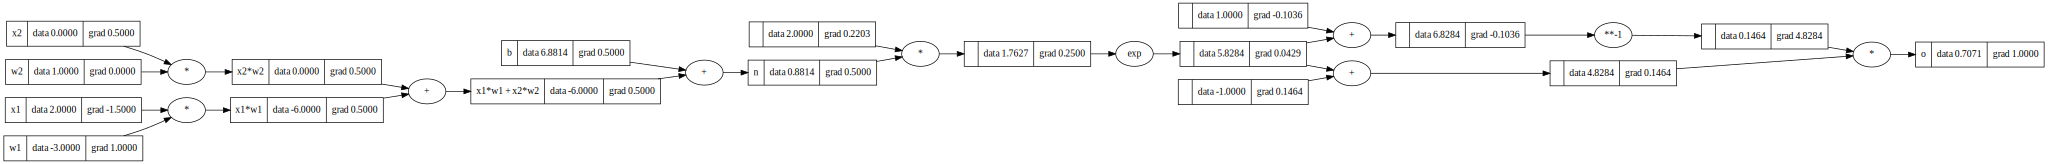

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)